In [1]:
import dotenv
import os

dotenv.load_dotenv(dotenv_path="secrets.env")
hf_token = os.getenv("HUGGINGFACE_API_KEY")

import os

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import dotenv

from tasks.hp.HPTask import HPTriviaTask
from tasks import HPSAQ
from tasks.hp.HPFamiliarity import HPCompletionsFamiliarity

from datetime import datetime

import tqdm
import torch

import matplotlib.pyplot as plt

/root/hp-unlrn/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_ckpt(folder, ckpt):
    adapter_folder = os.path.join(folder, "checkpoint-" + str(ckpt))
    return AutoModelForCausalLM.from_pretrained(adapter_folder, torch_dtype=torch.bfloat16).cuda()

In [3]:
def eval_model(model, tokenizer):
    hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_prompts.json')
    exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
    save_path = f'aengus_testing/datasets/llama-short-familiarity-completions-evaluated-{exp_time}.jsonl'
    hp_familiarity_task.generate_responses(model, tokenizer, save_path=save_path, eval_onthe_fly=True, eval_model='gpt-3.5-turbo', max_new_tokens=20, temperature=0, verbose=True, n_questions=20)
    familiarity, responses = hp_familiarity_task.get_accuracies()
    print(responses)
    return familiarity

In [4]:
model_ckpts = [10, 20, 40, 60, 80, 160]
model_folders = ["qa_instr_finetune", "dpo_finetune", "verbatim_finetune"]

tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    use_auth_token=hf_token
)

hp_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Llama2-7b-WhoIsHarryPotter",
    use_auth_token=hf_token,
    torch_dtype=torch.bfloat16
).cuda()

tokenizer.pad_token = tokenizer.eos_token

hp_acc = eval_model(hp_model, tokenizer)

del hp_model

for model_folder in model_folders:
    accuracies = [(0, hp_acc)]
    
    for ckpt in model_ckpts:
        adapted_model = load_ckpt(model_folder, ckpt)
        acc = eval_model(adapted_model, tokenizer)
        accuracies.append((ckpt, acc))
        del adapted_model

llama_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    use_auth_token=hf_token,
    torch_dtype=torch.bfloat16
).cuda()

base_acc = eval_model(llama_model, tokenizer)

/root/hp-unlrn/.env/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:711: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


/root/hp-unlrn/.env/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/root/hp-unlrn/.env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
  0%|                                                                                                                                                                                                     | 0/20 [00:00<?, ?it/s]/root/hp-unlrn/.env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set

defaultdict(<class 'int'>, {'3': 3, '0': 15, '2': 2})


OSError: qa_instruct_finetune/checkpoint-10 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

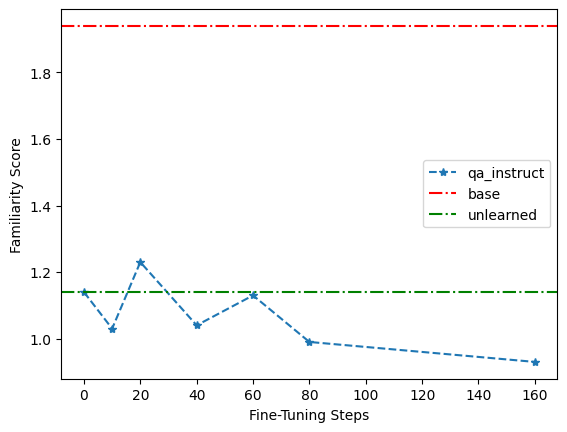

In [ ]:
x = [ckpt for ckpt, _ in accuracies]

keys = ["zero_shot"]
line_styles = ['--', '-', '-.']

#ys = [[acc[key] for _, acc in accuracies] for key in keys]
ys = [acc for _, acc in accuracies]

#for y, key in zip(ys, keys):
#    plt.plot(x, y, linestyle="--", marker="*", label="dpo_" + key)

for key, accs in zip(model_folders, ys):
    plt.plot(x, accs, linestyle="--", marker="*", label=key)

plt.xlabel('Fine-Tuning Steps')
plt.ylabel('Familiarity Score')

#for key, line_style in zip(keys, line_styles):
#    plt.axhline(y=base_acc[key], color='r', linestyle=line_style, label="base_" + key)
#    plt.axhline(y=hp_acc[key], color='g', linestyle=line_style, label="unlearned_" + key)

plt.axhline(y=base_acc, color='r', linestyle='-.', label="base")
plt.axhline(y=hp_acc, color='g', linestyle='-.', label="unlearned")

plt.legend()
plt.show()